# ISLR - Chapter 3

[Statsmodels](https://www.statsmodels.org/stable/index.html) and [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) both implement several regression algorithms. Scikit-learn provides an _awesome_ and consistent API for many other machine learning models as well.

I decided to stick with statsmodels for the Python port of the lab because the API is reminiscent of R. Ironically, my Python code below will look closer to the R lab than my R lab as my R code mostly used the [tidyverse](https://www.tidyverse.org/).

## Simple linear regression (3.6.2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

boston = pd.read_csv("BostonHousing.csv")
mod_lstat = smf.ols("medv ~ lstat", boston).fit()

Like in R, statsmodels' fitted regression objects provide a summary frame with common metrics as well as coefficients. The individual metrics are accessed via attributes on the [RegressionResults](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults) type returned by fitting the model.

The summary, RMSE, and coefficients are shown below.

In [2]:
print(mod_lstat.summary())
print(f"\n\nRMSE: {np.sqrt(mod_lstat.mse_resid)}\n\n")
print(mod_lstat.params)

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Thu, 11 Feb 2021   Prob (F-statistic):           5.08e-88
Time:                        09:40:47   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

### Predictions and intervals
Confidence and prediction intervals via statsmodels are slightly more involved compared to R. Statsmodels has several methods and functions that are used for prediction. The base **predict()** method returns an array with the values which can be added to the testing DataFrame. The **get_prediction()** method returns prediction and confidence intervals with a default $\alpha = 0.05$.

In [3]:
lstat_testing = pd.DataFrame({"lstat": [5, 10, 15]})
predict_lstat = mod_lstat.get_prediction(lstat_testing)
predict_lstat.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,29.803594,0.405247,29.007412,30.599776,17.565675,42.041513
1,25.053347,0.294814,24.474132,25.632563,12.827626,37.279068
2,20.303101,0.290893,19.731588,20.874613,8.077742,32.528459


Adding a column for the predictions is simple as well as useful.

In [4]:
lstat_testing["medv"] = mod_lstat.predict(lstat_testing)
lstat_testing.head()

,lstat,medv
0,5,29.803594
1,10,25.053347
2,15,20.303101


### Diagnostic plots

Text(0.5, 1.0, 'Boston median home value vs. % lower status')

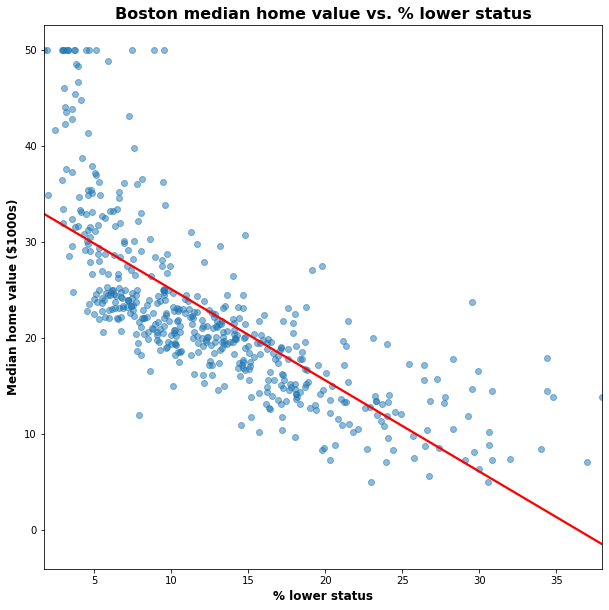

In [5]:
# Defaults for all plots
default_figsize = (10,10)
default_labs = {"fontweight": "bold",
               "size": 12}
default_title = {"fontweight": "bold",
                "size": 16}

# Figure and axes
mod_lstat_fig, mod_lstat_ax = plt.subplots(figsize=default_figsize)

# Plot and minor customization
sns.regplot(x="lstat", y="medv", data=boston,
            ci=None,
            line_kws={"color": "red"},
            scatter_kws={"alpha": 0.5},
            ax=mod_lstat_ax)

mod_lstat_ax.set_xlabel("% lower status", default_labs)
mod_lstat_ax.set_ylabel("Median home value ($1000s)", default_labs)
mod_lstat_ax.set_title("Boston median home value vs. % lower status",
                       default_title)

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Leverage plot'}, xlabel='Leverage', ylabel='Standardized residuals'>)

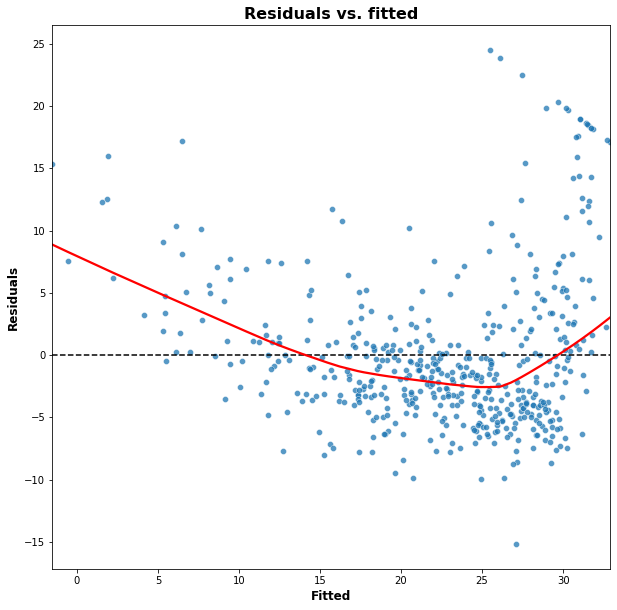

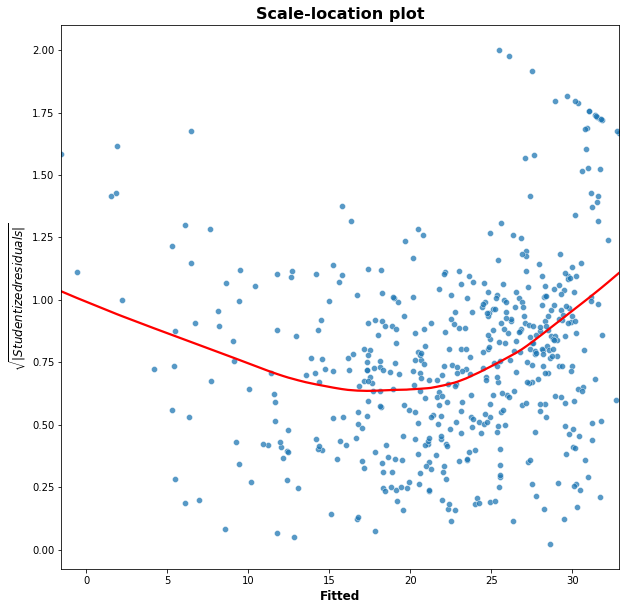

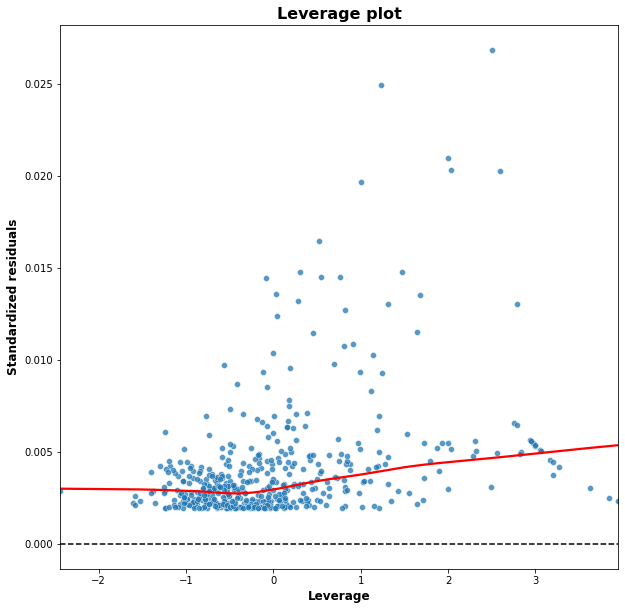

In [6]:
def diag_plots(model, diagnostic="residual", figsize=default_figsize,
              label_style=default_labs, title_style=default_title,
              alpha=0.75):
    # Variables to construct per plot type
    x = None
    y = None
    x_lab = ""
    y_lab = ""
    title = ""
    
    # We need the Figure and Axes early in case
    # we need an horizontal line
    fig, ax = plt.subplots(figsize=figsize)
    
    # Define x and y per plot type and
    # set the title and labels accordingly
    if diagnostic == "residual":
        # Residuals vs. fitted
        x = model.fittedvalues
        y = model.resid
        x_lab = "Fitted"
        y_lab = "Residuals"
        title = "Residuals vs. fitted"
        # Horizontal line at y=0
        ax.axhline(color="black",
                   linestyle="--")
    elif diagnostic == "scale_loc":
        # Square root of studentized residuals vs. fitted
        x = model.fittedvalues
        # Some of the residuals are negatives so I'm taking the
        # absolute value.
        y = np.sqrt(np.abs(model.get_influence().resid_studentized_external))
        x_lab = "Fitted"
        y_lab = "$\sqrt{|Studentized residuals|}$"
        title = "Scale-location plot"
    elif diagnostic == "leverage":
        # Standardized resid vs. leverage ("hat")
        # I didn't store get_influence()'s output
        # in a variable prior to the if/else because
        # only some cases use it.
        influence = model.get_influence()
        x = influence.resid_studentized_internal
        y = influence.hat_matrix_diag
        x_lab = "Leverage"
        y_lab = "Standardized residuals"
        title = "Leverage plot"
        # Horizontal line at y=0
        ax.axhline(color="black",
                   linestyle="--")
    else:
        raise ValueError
    
    # Scatter plot and lowess curve
    sns.scatterplot(x=x, y=y,
                   ci=None, alpha=alpha, ax=ax)
    sns.regplot(x=x, y=y,
                scatter=False, lowess=True,
                color="red", ax=ax)
    
    ax.set_xlabel(x_lab, label_style)
    ax.set_ylabel(y_lab, label_style)
    ax.set_title(title, title_style)
    
    return fig, ax
    
# And finally call it!
diag_plots(mod_lstat)
diag_plots(mod_lstat, "scale_loc")
diag_plots(mod_lstat, "leverage")   

Admittedly, statsmodel is _slightly_ more verbose than R here since we need to create a regression influence object.

The plots above are merely examples. One way to improve the leverage plot is to find the _n_ highest influential plots and label their indexes on the plot.

### Multiple linear regression (3.6.3)

In [7]:
mod_lstat_age = smf.ols("medv ~ lstat + age", boston).fit()

# Patsy formulas (which statsmodels uses) doesn't have the . notation
# to add all variables
X_all = sm.add_constant(boston.drop(columns="medv"))
y_full = boston.medv
mod_all = sm.OLS(y_full, X_all).fit()
print(mod_all.params)

const      36.459488
crim       -0.108011
zn          0.046420
indus       0.020559
chas        2.686734
nox       -17.766611
rm          3.809865
age         0.000692
dis        -1.475567
rad         0.306049
tax        -0.012335
ptratio    -0.952747
b           0.009312
lstat      -0.524758
dtype: float64


Variance inflation factor is also slightly more verbose via statsmodels. According to [this](https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python) Stack Overflow question, VIF requires an intercept which I added above anyway.

In [8]:
vif = pd.Series([variance_inflation_factor(X_all.values, col) for col in range(len(X_all.columns))],
                X_all.columns)

print(vif[1:])

crim       1.792192
zn         2.298758
indus      3.991596
chas       1.073995
nox        4.393720
rm         1.933744
age        3.100826
dis        3.955945
rad        7.484496
tax        9.008554
ptratio    1.799084
b          1.348521
lstat      2.941491
dtype: float64


Fitting a model by precluding specific variables:

In [9]:
mod_no_age = sm.OLS(y_full, X_all.drop(columns="age")).fit()

### Interaction terms (3.6.4)

In [10]:
mod_int_lage = smf.ols("medv ~ lstat * age", boston).fit()
print(mod_int_lage.params)

Intercept    36.088536
lstat        -1.392117
age          -0.000721
lstat:age     0.004156
dtype: float64


Interaction effects are simple to manually fit. Interactions are created by multiplying two variables to create a multiplicative relationship rather than an additive relationship. Linear models without interactions are additive so that each variable independently contribute to _y_ instead of having an additional combined effect.

In [11]:
X_interact = sm.add_constant(boston[["lstat", "age"]])
X_interact["lstat:age"] = X_interact.lstat * X_interact.age
mod_int_manual = sm.OLS(y_full, X_interact).fit()
print(mod_int_manual.params)

const        36.088536
lstat        -1.392117
age          -0.000721
lstat:age     0.004156
dtype: float64


### Non-linear transformations
My residual plot from earlier showed that `medv` and `lstat` likely have a non-linear relationship. The next task is to fit a model with a quadratic predictor followed by comparing the fits between the original and new models.

In [12]:
mod_lstat_sq = smf.ols("medv ~ lstat + I(lstat**2)", boston).fit()
print(mod_lstat_sq.params)

Intercept        42.862007
lstat            -2.332821
I(lstat ** 2)     0.043547
dtype: float64


Next we'll test if the RSS difference between the two models is statistical significant.

In [13]:
print(sm.stats.anova_lm(mod_lstat, mod_lstat_sq))

   df_resid           ssr  df_diff     ss_diff           F        Pr(>F)
0     504.0  19472.381418      0.0         NaN         NaN           NaN
1     503.0  15347.243158      1.0  4125.13826  135.199822  7.630116e-28


### Qualitative predictors (3.6.5)

In [14]:
carseats = pd.read_csv("carseats.csv")
X_car = carseats.drop(columns=["Sales"])
y_car = carseats.Sales

# Recode the categoricals as dummy variables
X_car = pd.get_dummies(X_car, drop_first=True)

# Interaction effects and constant/intercept
X_car["Income:Advertising"] = X_car.Income * X_car.Advertising
X_car["Price:Age"] = X_car.Price * X_car.Age
X_car = sm.add_constant(X_car)

mod_carseats_sales = sm.OLS(y_car, X_car).fit()
print(mod_carseats_sales.params)

const                 6.575565
CompPrice             0.092937
Income                0.010894
Advertising           0.070246
Population            0.000159
Price                -0.100806
Age                  -0.057947
Education            -0.020852
ShelveLoc_Good        4.848676
ShelveLoc_Medium      1.953262
Urban_Yes             0.140160
US_Yes               -0.157557
Income:Advertising    0.000751
Price:Age             0.000107
dtype: float64
